1. Какой моделью ARMA может быть описан ряд белого шума? Почему?

Модель ARMA(0,0). p = 0

Значения врменного ряда не зависят от его предыдущих значений/белого шума. ARMA(0,0) = M + E{t}

2. (2 баллa) Построит̆е модель ARIMA для временного ряда dow_jones_0. Сделайте прогноз на
30 точек вперед. Интерпретируйте полученный результат.

In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
import dataset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
%matplotlib inline

In [5]:
dataset = dataset.Dataset('../data/dataset/')

In [ ]:
ts = dataset['dow_jones_0.csv']

<AxesSubplot:xlabel='2018-11-30'>

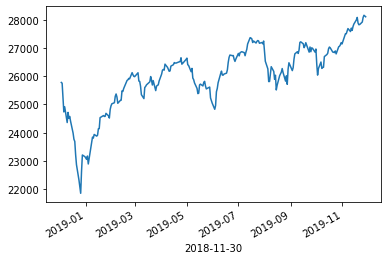

In [11]:
ts.plot()

In [77]:
split = int(len(ts)*0.85)

train, test = ts[:split], ts[split:]

In [70]:
adfuller(np.log(ts))[1]

0.7028237306682605

C:\Users\quel\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

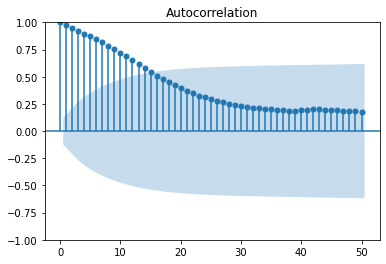

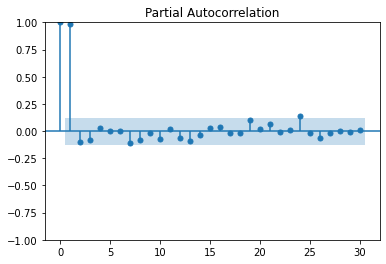

In [71]:
plot_acf(ts, lags = 50), plot_pacf(ts,lags = 30)

In [73]:
adfuller(ts.diff(1).dropna())[1]

7.270680965724108e-27

C:\Users\quel\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

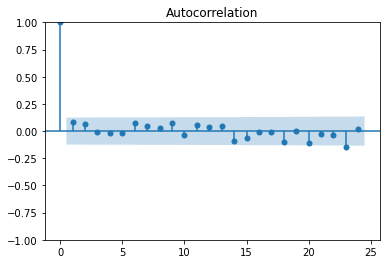

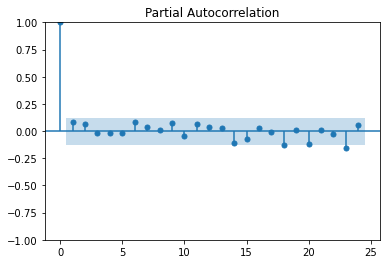

In [93]:
plot_acf(ts.diff(1).dropna()), plot_pacf(ts.diff(1).dropna())

In [37]:
from statsmodels.tsa.statespace import sarimax

In [119]:
pdq = (0, 1, 1)
PDQ = (0, 1, 1, 12)

ar = sarimax.SARIMAX(train, order=pdq, seasonal_order=PDQ)

res = ar.fit(maxiter=150)
pred = res.forecast(30)
pred.index = test.index[:30]

print(mse(test[:30], pred))

plotting.plot_ts(ts,pred)

C:\Users\quel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\quel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


627.2808793015621


C:\Users\quel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Loading BokehJS ...

3. (4 балла) Очень часто для решения тех или иных задач нам приходится определять период
   сезонности ряда. Мы это делаем, анализируя график временного ряда или его
   коррелограмму. Однако, если бы мы захотели автоматизировать решение задачи, нам
   пришлось бы придумать автоматический способ нахождения сезонности. Попробуйте
   реализовать функцию `get_seasonal_period(ts)` которая:
   а) Находит период сезонности по функции `acf`.
   б) Находит период сезонности через периодограмму (https://ru.wikipedia.org/wiki/Периодограмма).
      Реализацию такого разложения в python вы можете найти в scipy.signal.periodogram

In [624]:
from statsmodels.tsa.stattools import acf

from scipy import signal as sig
from sklearn.linear_model import LinearRegression
from pyloess import loess

In [197]:
long = dataset['daily-min-temperatures.csv']

sh = dataset['hour_3019.csv']

short_season_trend = dataset['international-airline-passengers.csv']

<AxesSubplot:xlabel='2019-05-30T10:00:00'>

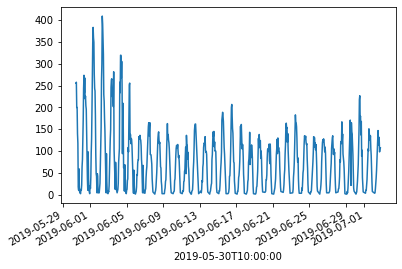

In [344]:
sh.plot()

<AxesSubplot:xlabel='1981-01-01'>

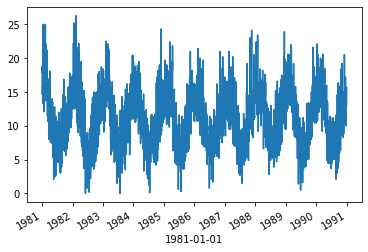

In [465]:
long.plot()

<AxesSubplot:xlabel='1949-01'>

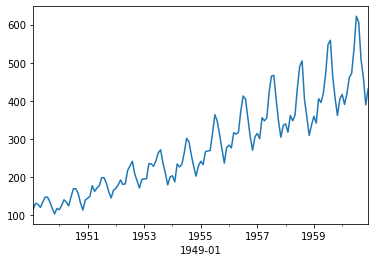

In [537]:
short_season_trend.plot()

In [642]:
def detrend_ts(ts, method = 'linear'):
    'Вычисляем тренд'
    if method == 'linear':
        model = LinearRegression()
        model.fit(np.arange(0,ts.shape[0]).reshape(-1,1),ts.values)
        trend = model.predict(np.arange(0,ts.shape[0]).reshape(-1,1))
    else:
        trend = loess(np.arange(0, len(ts.index)),ts.values,np.arange(0, len(ts.index)), degree = 1, span = .3)
        det = ts - trend
    
    return trend

In [643]:
def get_seasonal_period(ts, method = 'linear'):
    """Возвращает сезонность ряда"""

    trend = detrend_ts(ts,method = method)
    det = ts - trend
    
        
    #Фурье преобразование
    four = np.fft.rfft(det)
    mag = np.abs(four)
    
    #Частота
    freq = np.fft.rfftfreq(ts.shape[0])
    freq = 1/freq
    
    plt.plot(freq,mag)
    plt.title('Periodogramma')
    

    return round(pd.Series(data = mag, index = freq).sort_values(ascending=False).index[0])
    

C:\Users\quel\AppData\Local\Temp\ipykernel_3096\3470079996.py:14: RuntimeWarning: divide by zero encountered in true_divide
  freq = 1/freq


365

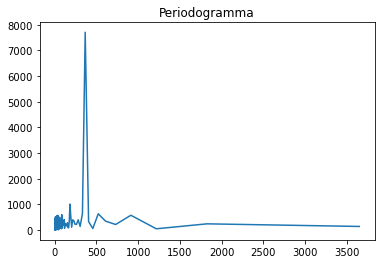

In [644]:
get_seasonal_period(long,method='linea')

C:\Users\quel\AppData\Local\Temp\ipykernel_3096\3470079996.py:14: RuntimeWarning: divide by zero encountered in true_divide
  freq = 1/freq


23

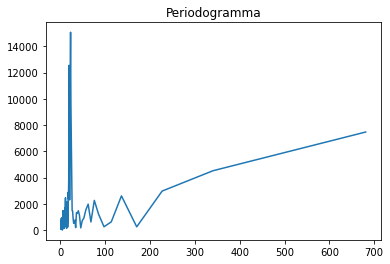

In [646]:
get_seasonal_period(sh,method='linear')

C:\Users\quel\AppData\Local\Temp\ipykernel_3096\3470079996.py:14: RuntimeWarning: divide by zero encountered in true_divide
  freq = 1/freq


12

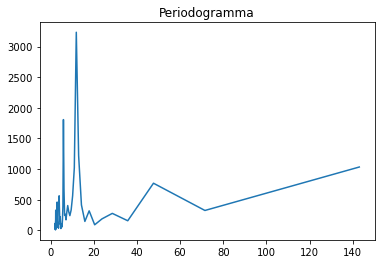

In [655]:
get_seasonal_period(short_season_trend,method='linear')